In [1]:
# funcs
%reload_ext autoreload
%autoreload 2
from denn import *
from fastai.callbacks import * 
import torch
import torch.nn.functional as F
from torch import nn

Experiment = Enum('Experiment', 'exp1 exp2 exp3 exp4')
Method = Enum('Methods', 'noNNRestart noNNReval NNnorm NNdrop')
FuncName = Enum('FuncName', 'sphere rastrigin ackley rosenbrock')
class DropoutModel(nn.Module):
    def __init__(self, d:int, w:int, nf:int, dropout:float=0.5):
        super().__init__()
        self.fc1 = nn.Linear(d,nf)
        self.fc2 = nn.Linear(nf*w,d)
        self.act = nn.ReLU(inplace=True)
        self.dropout = dropout
        
    def forward(self, x):
        fts = torch.cat([self.fc1(x[:,i]) for i in range(x.size(1))], dim=1)
        return self.fc2(F.dropout(self.act(fts), p=self.dropout))

class SimpleModel(nn.Module):
    def __init__(self, d, w, nf):
        super().__init__()
        self.fc1 = nn.Linear(d,nf)
        self.fc2 = nn.Linear(nf*w,d)
        self.act = nn.ReLU(inplace=True)
        
    def forward(self, x):
        fts = torch.cat([self.fc1(x[:,i]) for i in range(x.size(1))], dim=1)
        return self.fc2(self.act(fts))

def get_functions(experiment:Experiment, D:int, func_name:FuncName)->Collection[Callable]:
    if func_name==FuncName.sphere:
        if experiment in [Experiment.exp1, Experiment.exp2]:
            def fitness_func(indiv, b, t): return (indiv.data**2).sum()
            def constraint_func(indiv, b, t): return -b[t] + sum((1/np.sqrt(D))*indiv.data)
        elif experiment == Experiment.exp3:
            def fitness_func(indiv, b, t): return ((indiv.data + 0.1*t)**2).sum()
            def constraint_func(indiv, b, t): return 0
        elif experiment == Experiment.exp4:
            def fitness_func(indiv, b, t): return ((indiv.data-b[t]*np.sin(np.pi/2*t))**2).sum()
            def constraint_func(indiv, b, t): return 0
    elif func_name==FuncName.rastrigin:
        if experiment in [Experiment.exp1, Experiment.exp2]:
            def fitness_func(indiv, b, t): return 10*D+((indiv.data**2)-10*np.cos(2*np.pi*indiv.data)).sum()
            def constraint_func(indiv, b, t): return -b[t] + sum((1/np.sqrt(D))*indiv.data)
        elif experiment == Experiment.exp3:
            def fitness_func(indiv, b, t): return 10*D+(((indiv.data+0.1*t)**2)-10*np.cos(2*np.pi*indiv.data)).sum()
            def constraint_func(indiv, b, t): return 0
        elif experiment == Experiment.exp4:
            def fitness_func(indiv, b, t): return 10*D+(((indiv.data-b[t]*np.sin(np.pi/2*t))**2)-10*np.cos(2*np.pi*indiv.data)).sum()
            def constraint_func(indiv, b, t): return 0                
    elif func_name==FuncName.rosenbrock:
        if experiment in [Experiment.exp1, Experiment.exp2]:
            def fitness_func(indiv, b, t): return ((100 * (indiv.data[1:] - indiv.data[:-1]**2)**2) + (1-indiv.data[:-1])**2).sum()
            def constraint_func(indiv, b, t): return -b[t] + sum((1/np.sqrt(D))*indiv.data)
        elif experiment == Experiment.exp3:
            def fitness_func(indiv, b, t): return ((100 * ((indiv.data[1:]+0.1*t) - (indiv.data[:-1]+0.1*t)**2)**2) + (1-indiv.data[:-1]-0.1*t)**2).sum()
            def constraint_func(indiv, b, t): return 0
        elif experiment == Experiment.exp4:
            def fitness_func(indiv, b, t): return (((100 * ((indiv.data[1:]-b[t]*np.sin(np.pi/2*t)) - (indiv.data[:-1]-b[t]*np.sin(np.pi/2*t))**2)**2) + (1-indiv.data[:-1]+b[t]*np.sin(np.pi/2*t))**2)).sum()
            def constraint_func(indiv, b, t): return 0  
    return fitness_func,constraint_func

In [2]:
# params
experiment = 'exp3'
func_name = 'sphere'
method = 'NNnorm'
replace_mech = 'Worst'
D = 30
frequency = 0.5
max_times = 100
nn_window = 5
nn_nf = 4
nn_pick = 3
nn_sample_size = 3
nn_train_window = 5
batch_size = 4
nn_epochs = 3
evolve_with_best = False
cluster = False

In [3]:
# Build opt
# Setting variables
experiment_type = getattr(Experiment, experiment)
method_type = getattr(Method, method)
func_type = getattr(FuncName, func_name)
path = Path(f'../../data/results/{experiment}/{func_name}')
if cluster: path = Path(f'DENN/data/cluster_results/{experiment}/{func_name}') # this is for the cluster
fitness_func,constraint_func = get_functions(experiment_type, D, func_type)
is_nn = method_type in [Method.NNnorm, Method.NNdrop]
experiment_name = f'{method}'
total_generations = int(max_times * frequency * 1_000_000 + 1_000)
if is_nn:
    experiment_name += f'_{replace_mech}'
    replace_type = getattr(ReplaceMechanism, replace_mech)

# Read files
if cluster:
    tmp_path = Path(f'DENN/data/results/{experiment}/{func_name}')
    ab = pd.read_csv(tmp_path/'dC_01.csv')['b'].values
    df = pd.read_csv(tmp_path/'best_known.csv')
    best_known_fitness = df['fitness'].values
    best_known_sumcv   = df['sum_constraints'].values
else:
    ab = pd.read_csv(path/'dC_01.csv')['b'].values
    df = pd.read_csv(path/'best_known.csv')
    best_known_fitness = df['fitness'].values
    best_known_sumcv   = df['sum_constraints'].values

# Initialize metrics
results = {'mof':[], 'sr':[], 'nfe':[], 'fitness':[], 'sumcv':[], 'arr':[]}
if is_nn: results['nn_time'] = []

# Run
callbacks = []
if is_nn:
    if method_type==Method.NNnorm:
        model = SimpleModel (d=D, w=nn_window, nf=nn_nf) 
        nn_trainer = partial(NNTrainer, model=model, n=nn_pick, sample_size=nn_sample_size, window=nn_window,
                             train_window=nn_train_window, replace_mechanism=replace_type, bs=batch_size, epochs=nn_epochs)
    if method_type==Method.NNdrop:
        model = DropoutModel(d=D, w=nn_window, nf=nn_nf, dropout=dropout) 
        nn_trainer = partial(NNTrainerNoNoise  , model=model, n=nn_pick, sample_size=nn_sample_size, window=nn_window,
                             train_window=nn_train_window, replace_mechanism=replace_type, bs=batch_size, epochs=nn_epochs)

    callbacks.append(nn_trainer)
elif method_type==Method.noNNRestart:
    callbacks.append(OnChangeRestartPopulation)
#first pop created here and passed to optimization
population = Population.new_random(dimension=D)
speed_metric = partial(SpeedMetric, threadhold=0.1)
opt = Optimization(population, fitness_func, constraint_func, fitness_params=ab, constraint_params=[ab],
                   max_times=max_times, frequency=frequency, callbacks=callbacks,
                   metrics=[speed_metric, ModifiedOfflineError, OfflineError, AbsoluteRecoverRate],
                   optimal_fitness_values=best_known_fitness, optimal_sum_constraints=best_known_sumcv, evolve_with_best=evolve_with_best)

Total time: 35:14
SpeedMetric(success rate): 0.5800
ModifiedOfflineError: 0.0531
OfflineError: 0.0531
AbsoluteRecoverRate: 0.6827
NNTimer: 0.0020


BdbQuit: 

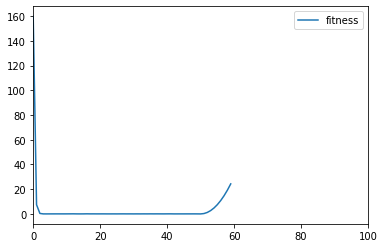

In [5]:
opt.run(total_generations)

In [5]:
0 / (69 * abs(67.5 - 67.5))

ZeroDivisionError: float division by zero

In [ ]:
self.acummulated_sum

In [5]:
opt.absolute_recover_rate

AbsoluteRecoverRate: nan

In [6]:
opt.absolute_recover_rate.time_values

[0.2993516408168555,
 0.7143501414325095,
 0.6646855866522011,
 0.7107566564055705,
 0.6419291286762709,
 0.5527776500118655,
 0.6578951309020755,
 0.5641787497912545,
 0.5572736451714176,
 0.5986231168267186,
 0.5594777393833865,
 0.5938893129289736,
 0.5055691012446136,
 0.6522784210544813,
 0.6186411728506788,
 0.584220415764027,
 0.6350597989859474,
 0.5999697537415905,
 0.5314886570260379,
 0.5993719650807183,
 0.532867299445297,
 0.5320198867451803,
 0.48862787461062324,
 0.3581237332188824,
 0.5927729164288895,
 0.547827341207638,
 0.6402138761933205,
 0.5848931775233213,
 0.6530872090842869,
 0.5744863854639723,
 0.5683324496517794,
 0.6029507621240391,
 0.5644062036950672,
 0.6573220952084876,
 0.6219133851328712,
 0.5588768043286293,
 0.5930387044920337,
 0.5510668450133617,
 0.5529926361360387,
 0.5258181438895145,
 0.613801718206402,
 0.5842000070201308,
 0.5930121537497364,
 0.5697499720190208,
 0.5860801877742982,
 0.5324223492820761,
 0.600480598474109,
 0.62016216092310